In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from pathlib import Path
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import risk_matrix
import os

# Load Data

In [20]:
tickers = ['AAPL', 'AMZN', 'BA', 'COST', 'JNJ', 'NVDA', 'TMO', 'TSLA', 'VLO']
data_dir = "Data"
features = ['close']

all_data = {}
min_length = float('inf')


for stock in tickers:
    df = pd.read_csv(os.path.join(data_dir, f"{stock}_daily_aggregated.csv"))
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))


    # 合并情绪数据
    df['date'] = pd.to_datetime(df['date'])
    # 清理和填充空值
    df = df.dropna().reset_index(drop=True)

    all_data[stock] = df
    min_length = min(min_length, len(df))  # 用于对齐长度

for stock in tickers:
    all_data[stock] = all_data[stock].tail(min_length).reset_index(drop=True)
    all_data[stock] = all_data[stock][["date","close"]]



In [21]:
close_price_list = []

for ticker, df in all_data.items():
    df = df[['date', 'close']].copy()
    df['date'] = pd.to_datetime(df['date'])  
    df.set_index('date', inplace=True)
    df.rename(columns={'close': ticker}, inplace=True)
    close_price_list.append(df)


close_df = pd.concat(close_price_list, axis=1)
close_df = close_df.sort_index()
close_df


,AAPL,AMZN,BA,COST,JNJ,NVDA,TMO,TSLA,VLO
date,,,,,,,,,
2021-01-05,127.7365,160.7550,211.3000,356.6557,139.3333,13.3759,472.7761,249.7867,48.7026
2021-01-06,123.9804,157.1575,211.2400,351.2073,140.6264,12.6792,480.1886,254.2500,49.4707
2021-01-07,127.4439,158.4420,210.3000,349.8499,141.3654,13.2540,495.1521,276.4833,50.0277
2021-01-08,128.9268,159.0995,209.9900,351.1670,140.7848,13.2473,506.9982,293.2667,48.7109
2021-01-11,125.8050,155.7285,205.8400,345.5120,140.1954,13.5899,511.3527,270.4600,49.5382
...,...,...,...,...,...,...,...,...,...
2025-05-23,195.2694,200.7890,193.6696,1007.3350,151.3065,131.2600,393.6600,339.9900,128.9000
2025-05-27,200.2654,205.9100,201.1800,1018.0000,153.2100,135.2500,405.4000,362.7800,130.7100
2025-05-28,200.3800,205.6600,201.9000,1014.5100,152.0325,141.7700,404.0000,361.8500,127.0100


In [22]:
sp = pd.read_csv("sp500.csv")
sp.date = pd.to_datetime(sp.date)
market_close_df = sp[["date","close"]]
market_close_df.set_index("date", inplace = True)
market_close_df

,close
date,
2021-01-05,371.33
2021-01-06,373.55
2021-01-07,379.10
2021-01-08,381.26
2021-01-11,378.69
...,...
2025-05-23,579.11
2025-05-27,591.15
2025-05-28,587.73


In [23]:
rf_df = pd.read_csv("rf.csv")
rf_df.drop(columns = "Unnamed: 0", inplace = True)
daily_rfr = rf_df.set_index("date")
daily_rfr.index = pd.to_datetime(daily_rfr.index)
daily_rfr

,rf_daily
date,
2021-01-04,0.000004
2021-01-05,0.000004
2021-01-06,0.000004
2021-01-07,0.000004
2021-01-08,0.000003
...,...
2025-06-12,0.000177
2025-06-13,0.000177
2025-06-16,0.000176


# Find Tangency Portfolio using CAPM Based Expected Return

In [24]:
from sklearn.linear_model import LinearRegression
from pypfopt.risk_models import sample_cov
from pypfopt.efficient_frontier import EfficientFrontier

# Ensure sorted dates
close_df = close_df.sort_index()
market_close_df = market_close_df.sort_index()
stocks = close_df.columns.tolist()

window = 252
rebalance_every = 21
dynamic_weights = {}

for t in range(window, len(close_df) - 1):
    current_date = close_df.index[t]

    # === Risk-Free Rate (annualized from daily) ===
    rf_row = daily_rfr.loc[daily_rfr.index.normalize() == current_date, "rf_daily"]
    if not rf_row.empty:
        risk_free_rate = (1 + rf_row.values[0]) ** 252 - 1
    else:
        risk_free_rate = 0.0

    # === Rebalance only every N days ===
    if (t - window) % rebalance_every != 0:
        if dynamic_weights:
            dynamic_weights[current_date] = dynamic_weights[list(dynamic_weights.keys())[-1]]
        continue

    # === Get window data ===
    window_data = close_df.iloc[t - window:t]
    market_window = market_close_df.iloc[t - window:t]
    if window_data.isnull().values.any() or market_window.isnull().values.any():
        continue

    # === Compute returns ===
    asset_returns = window_data.pct_change().dropna()
    market_returns = market_window.pct_change().dropna()

    # === Align dates ===
    common_index = asset_returns.index.intersection(market_returns.index)
    asset_returns = asset_returns.loc[common_index]
    market_returns = market_returns.loc[common_index]
    rf_daily_window = daily_rfr.loc[common_index].fillna(0)

    # === Excess returns ===
    excess_market = market_returns["close"] - rf_daily_window["rf_daily"]
    excess_assets = asset_returns.sub(rf_daily_window["rf_daily"], axis=0)

    # === Estimate beta via linear regression ===
    betas = {}
    for asset in excess_assets.columns:
        X = excess_market.values.reshape(-1, 1)
        y = excess_assets[asset].values.reshape(-1, 1)
        reg = LinearRegression().fit(X, y)
        betas[asset] = reg.coef_[0][0]

    # === Compute CAPM expected returns ===
    mu_market = market_returns["close"].mean() * 252
    rf_annual = (1 + rf_daily_window["rf_daily"].mean()) ** 252 - 1

    mu_capm = pd.Series({
        asset: rf_annual + beta * (mu_market - rf_annual)
        for asset, beta in betas.items()
    })

    # === Covariance matrix ===
    S = sample_cov(window_data, frequency=252)

    # === Align assets ===
    common_assets = mu_capm.index.intersection(S.columns)
    mu_capm = mu_capm.loc[common_assets]
    S = S.loc[common_assets, common_assets]

    # Fallback to historical mean return if no CAPM asset beats r_f
    if (mu_capm - risk_free_rate <= 0).all():
        print(f"⚠️ {current_date.date()}: CAPM returns too low. Using historical mean return instead.")
        mu_hist = window_data.pct_change().mean() * 252
        mu_hist = mu_hist.loc[common_assets]
        mu_used = mu_hist
    else:
        mu_used = mu_capm

    # === Portfolio optimization ===
    try:
        ef = EfficientFrontier(mu_used, S, weight_bounds=(-1.5, 1.5))
        ef.max_sharpe(risk_free_rate=risk_free_rate)
        cleaned_weights = ef.clean_weights()
        dynamic_weights[current_date] = pd.Series(cleaned_weights)
    except Exception as e:
        print(f"⚠️ Optimization failed on {current_date.date()} using max Sharpe: {e}")
        try:
            # Fallback: global minimum variance portfolio
            ef = EfficientFrontier(None, S, weight_bounds=(-1.5, 1.5))
            ef.min_volatility()
            cleaned_weights = ef.clean_weights()
            dynamic_weights[current_date] = pd.Series(cleaned_weights)
            print(f"✅ Fallback to GMV succeeded on {current_date.date()}")
        except Exception as e2:
            print(f"❌ Fallback to GMV also failed on {current_date.date()}: {e2}")
            continue

# === Final weights DataFrame ===
weights_df = pd.DataFrame(dynamic_weights).T
weights_df = weights_df.reindex(close_df.index).fillna(method='ffill').fillna(0)


⚠️ 2022-06-06: CAPM returns too low. Using historical mean return instead.
⚠️ 2022-07-07: CAPM returns too low. Using historical mean return instead.
⚠️ 2022-08-05: CAPM returns too low. Using historical mean return instead.
⚠️ 2022-09-06: CAPM returns too low. Using historical mean return instead.
⚠️ 2022-10-05: CAPM returns too low. Using historical mean return instead.
⚠️ 2022-11-03: CAPM returns too low. Using historical mean return instead.
⚠️ 2022-12-05: CAPM returns too low. Using historical mean return instead.
⚠️ 2023-01-05: CAPM returns too low. Using historical mean return instead.
⚠️ 2023-02-06: CAPM returns too low. Using historical mean return instead.
⚠️ 2023-03-08: CAPM returns too low. Using historical mean return instead.
⚠️ 2023-04-06: CAPM returns too low. Using historical mean return instead.
⚠️ 2023-05-08: CAPM returns too low. Using historical mean return instead.


/var/folders/w_/wzxdnvq13mxbxkhjgg1mty_80000gn/T/ipykernel_24774/3722444315.py:105: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weights_df = weights_df.reindex(close_df.index).fillna(method='ffill').fillna(0)


# Output and Evaluation

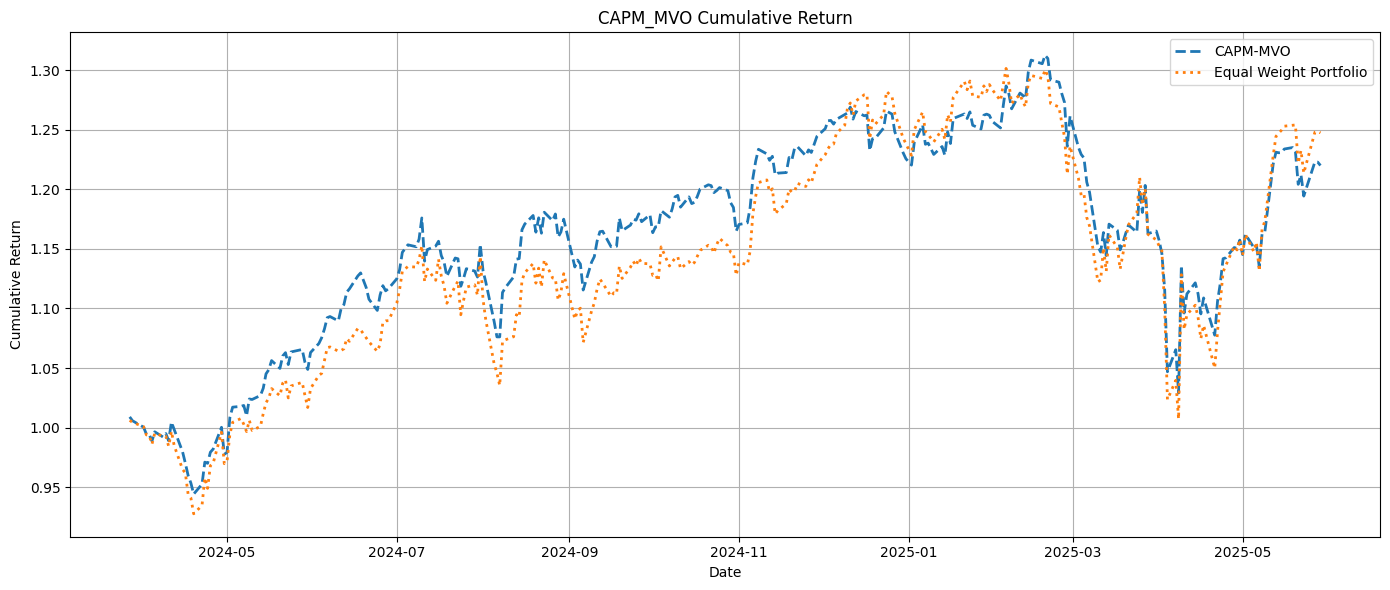

In [25]:
import matplotlib.pyplot as plt

# 1. Calculate daily returns
returns_df = close_df.pct_change().fillna(0)

# 2. Align weights and returns
start_date = pd.to_datetime("2024-03-27")
end_date = pd.to_datetime("2025-05-29")
returns_df = returns_df.loc[start_date:end_date]
weights_df_eval = weights_df.loc[start_date:end_date]

# Match dates and ensure weights & returns align
common_dates = returns_df.index.intersection(weights_df_eval.index)
returns_df = returns_df.loc[common_dates]
weights_df_eval = weights_df_eval.loc[common_dates]

# 3. Compute daily portfolio returns
# (row-wise dot product of weights and asset returns)
port_returns = (weights_df_eval * returns_df).sum(axis=1)
equal_weights = np.ones(len(tickers)) / len(tickers)
equal_returns = (returns_df.values * equal_weights).sum(axis=1)


# 4. Compute cumulative returns
cumulative_returns = (1 + port_returns).cumprod()
cumulative_equal = (1 + equal_returns).cumprod()

# 5. Plot cumulative return
plt.figure(figsize=(14, 6))
plt.plot(cumulative_returns.index, cumulative_returns, label='CAPM-MVO', linestyle='--', linewidth=2)
plt.plot(cumulative_returns.index, cumulative_equal, label='Equal Weight Portfolio', linestyle=':', linewidth=2)
plt.title("CAPM_MVO Cumulative Return")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


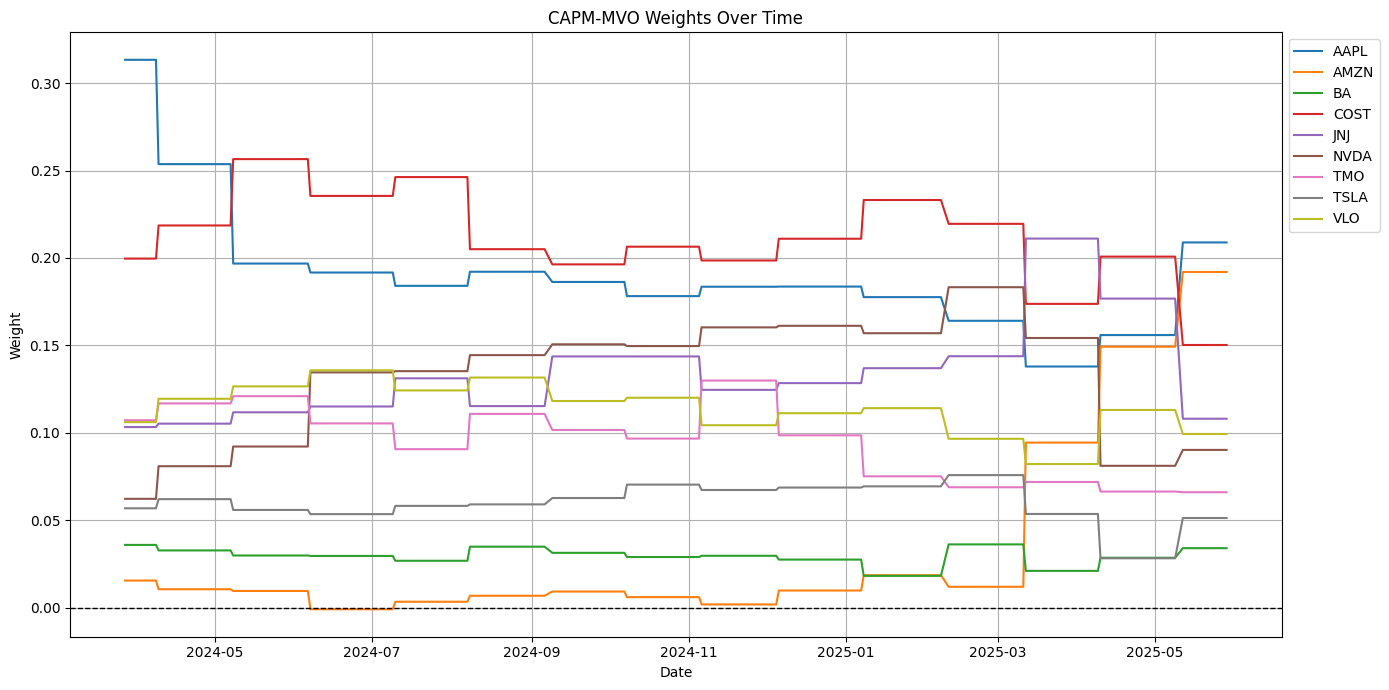

In [26]:
# 6. Plot weights over time (line plot for long/short portfolios)
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
for col in weights_df_eval.columns:
    plt.plot(weights_df_eval.index, weights_df_eval[col], label=col)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title("CAPM-MVO Weights Over Time")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
def calculate_metrics(returns, var_conf_level=0.95):
    returns = pd.Series(returns)
    cumulative = (1 + returns).cumprod()
    total_return = cumulative.iloc[-1] - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
    max_drawdown = (cumulative / cumulative.cummax() - 1).min()
    
    # Historical Value at Risk (e.g., 5% worst return)
    var_percentile = 100 * (1 - var_conf_level)
    value_at_risk = np.percentile(returns, var_percentile)

    return total_return, annualized_return, volatility, sharpe_ratio, max_drawdown, value_at_risk


In [28]:
# Calculate metrics
port_metrics = calculate_metrics(port_returns)

# Unpack results
total_return, annualized_return, volatility, sharpe_ratio, max_drawdown, value_at_risk = port_metrics

# Print results nicely
print("\n📊 Portfolio Performance Metrics:")
print(f"Total Return:        {total_return:.2%}")
print(f"Annualized Return:   {annualized_return:.2%}")
print(f"Volatility:          {volatility:.2%}")
print(f"Sharpe Ratio:        {sharpe_ratio:.4f}")
print(f"Max Drawdown:        {max_drawdown:.2%}")
print(f"Value at Risk (5%):  {value_at_risk:.2%}")



📊 Portfolio Performance Metrics:
Total Return:        21.99%
Annualized Return:   18.58%
Volatility:          22.03%
Sharpe Ratio:        0.8432
Max Drawdown:        -21.59%
Value at Risk (5%):  -2.04%
